In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv("transactions_n100000.csv")

In [3]:
data1 = data.drop(['lat','long'],axis = 1)
data1 = pd.get_dummies(data1,columns = ['item_name'])
data2 = data1.copy()
data2['item_name_burger'] = data1['item_count'].mul(data1['item_name_burger'])
data2['item_name_fries'] = data1['item_count'].mul(data1['item_name_fries'])
data2['item_name_salad'] = data1['item_count'].mul(data1['item_name_salad'])
data2['item_name_shake'] = data1['item_count'].mul(data1['item_name_shake'])
data2 = data2.drop(['item_count'],axis = 1)
data2_mode = data2[['ticket_id','order_timestamp','location']].groupby(['ticket_id']).agg(pd.Series.mode)
data2_sum = data2[['ticket_id','item_name_burger','item_name_fries','item_name_salad','item_name_shake']].groupby(['ticket_id']).sum()

In [4]:
data3 = data2_mode.copy()
data3[['item_name_burger','item_name_fries','item_name_salad','item_name_shake']] = data2_sum[['item_name_burger','item_name_fries','item_name_salad','item_name_shake']]
date_time = list(data3.order_timestamp)
time = []
day = []
for i in date_time:
    time.append(str(i.split(" ")[1].split(":")[0]))
    day.append(str(datetime.strptime(i.split(" ")[0], "%Y-%m-%d").weekday()+1))
data4 = data3.drop('order_timestamp',axis = 1)
data4['day'] = day
data4['time'] = time
data4['location'] = data3['location'].apply(str)
data5 = data4.copy()
for c in data4.select_dtypes(exclude='object').columns:
    data5[c] = scale(np.array(data4[c]).reshape(-1, 1))

In [5]:
for c in data4.select_dtypes(exclude='object').columns:
    data5[c] = scale(np.array(data4[c]).reshape(-1, 1))
data5.corr()

,item_name_burger,item_name_fries,item_name_salad,item_name_shake
item_name_burger,1.000000,0.737587,-0.558611,0.843537
item_name_fries,0.737587,1.000000,0.148049,0.701562
item_name_salad,-0.558611,0.148049,1.000000,-0.373705
item_name_shake,0.843537,0.701562,-0.373705,1.000000


In [6]:
###Since these four features are highly correlated, decided to do PCA

In [7]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(np.array(data5[data5.select_dtypes(exclude='object').columns]))

[0.66586813 0.28638205]
[0.66586813 0.95225018]


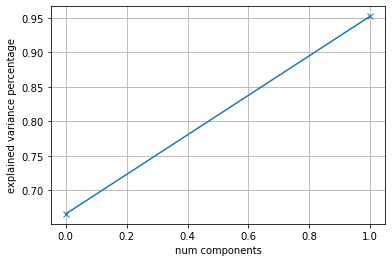

In [8]:
explained_var = pca.explained_variance_ratio_
print(explained_var)
cumsum = np.cumsum(explained_var)
print(cumsum)
ax = plt.subplot()
ax.plot(np.arange(0, 2), cumsum, '-x')
ax.grid()
ax.set_xlabel('num components')
ax.set_ylabel('explained variance percentage')
plt.show()

In [9]:
pca.components_
###So component1 = burger fries and shake, component2 = salad and fries

array([[ 0.5995444 ,  0.48132171, -0.28687802,  0.57146909],
       [-0.09323673,  0.55886065,  0.82301878,  0.04027129]])

In [10]:
data_part = pd.DataFrame(X_reduced)

In [11]:
data5 = data5.drop(['item_name_burger','item_name_fries','item_name_salad','item_name_shake'],axis = 1)
data5['burger_fries_shake'] = list(data_part[0])
data5['salad_fries'] = list(data_part[1])
data6 = pd.get_dummies(data5,columns = ['location','day','time'])

In [12]:
data6.head()

,burger_fries_shake,salad_fries,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,...,time_14,time_15,time_16,time_17,time_18,time_19,time_20,time_21,time_22,time_23
ticket_id,,,,,,,,,,,,,,,,,,,,,
0x100048,-1.587167,1.996741,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x100057,-1.138834,-1.177243,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0x1000ba,-0.690881,0.025758,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x1000fb,2.578659,1.182329,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
0x10016e,1.392032,-0.381449,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [13]:
SSE = []
for k in range(1,8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data6)
    SSE.append(kmeans.inertia_)

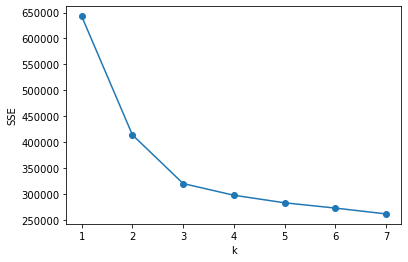

In [14]:
X = range(1,8)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

In [15]:
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(data6)
gmm_3 = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm_3.fit(data6)

GaussianMixture(n_components=3)

In [16]:
label_gmm_3 = gmm_3.predict(data6)
label_kmean_3 = kmeans_3.predict(data6)

In [17]:
data_gmm = data4.copy()
data_kmeans = data4.copy()
data_gmm['label'] = list(label_gmm_3)
data_kmeans['label'] = list(label_kmean_3)
data_gmm.to_csv('data_gmm_3.csv')

In [18]:
data4.head()

,location,item_name_burger,item_name_fries,item_name_salad,item_name_shake,day,time
ticket_id,,,,,,,
0x100048,1,0,3,3,0,5,12
0x100057,6,1,1,0,0,7,00
0x1000ba,5,1,2,1,1,6,12
0x1000fb,4,4,5,1,4,6,19
0x10016e,7,3,3,0,3,5,17


In [19]:
tb1 = pd.crosstab(label_gmm_3,data4.item_name_salad, margins=True)
tb1

item_name_salad,0,1,2,3,4,5,All
row_0,,,,,,,
0,32092,1344,144,91,24,9,33704
1,27599,5481,660,193,49,14,33996
2,1965,11034,10439,6722,1449,691,32300
All,61656,17859,11243,7006,1522,714,100000


In [20]:
tb2 = pd.crosstab(label_gmm_3,data4.item_name_burger, margins=True)
tb2

item_name_burger,0,1,2,3,4,5,All
row_0,,,,,,,
0,637,16724,11421,1760,1660,1502,33704
1,683,2202,4141,8359,13405,5206,33996
2,22566,8278,1180,139,101,36,32300
All,23886,27204,16742,10258,15166,6744,100000


In [22]:
tb3 = pd.crosstab(label_gmm_3,data4.item_name_fries, margins=True)
tb3

item_name_fries,1,2,3,4,5,All
row_0,,,,,,
0,16625,11878,1834,1676,1691,33704
1,1915,3626,6846,14893,6716,33996
2,9579,9743,9619,1749,1610,32300
All,28119,25247,18299,18318,10017,100000


In [24]:
tb4 = pd.crosstab(label_gmm_3,data4.item_name_shake, margins=True)
tb4

item_name_shake,0,1,2,3,4,5,All
row_0,,,,,,,
0,24169,8331,1094,99,11,0,33704
1,980,2426,5078,9659,11941,3912,33996
2,28568,3358,198,75,78,23,32300
All,53717,14115,6370,9833,12030,3935,100000


In [25]:
tb5 = pd.crosstab(label_gmm_3,data4.time, margins=True)
tb5

time,00,01,11,12,13,14,15,16,17,18,19,20,21,22,23,All
row_0,,,,,,,,,,,,,,,,
0,22837,5432,0,0,0,0,0,0,0,0,0,0,0,0,5435,33704
1,0,0,0,0,0,0,0,2115,8058,12967,8287,2199,370,0,0,33996
2,0,0,8084,12924,8330,2208,560,0,0,0,0,0,0,194,0,32300
All,22837,5432,8084,12924,8330,2208,560,2115,8058,12967,8287,2199,370,194,5435,100000


In [26]:
tb5 = pd.crosstab(label_gmm_3,data4.day, margins=True)
tb5

day,1,2,3,4,5,6,7,All
row_0,,,,,,,,
0,4853,4798,4803,4801,4816,4845,4788,33704
1,4841,4868,4916,4812,4929,4836,4794,33996
2,4584,4604,4580,4573,4695,4554,4710,32300
All,14278,14270,14299,14186,14440,14235,14292,100000


In [28]:
tb5 = pd.crosstab(label_gmm_3,data4.location, margins=True)
tb5

location,1,2,3,4,5,6,7,8,9,All
row_0,,,,,,,,,,
0,1115,13348,1079,1013,716,13270,1015,1116,1032,33704
1,1169,1074,1189,8974,1194,1037,8843,1471,9045,33996
2,6398,1349,6423,1351,6397,1300,1379,6375,1328,32300
All,8682,15771,8691,11338,8307,15607,11237,8962,11405,100000


In [29]:
tb6 = pd.crosstab(data4.day,data4.location, margins=True)
tb6

location,1,2,3,4,5,6,7,8,9,All
day,,,,,,,,,,
1,1239,2223,1257,1600,1132,2259,1565,1349,1654,14278
2,1227,2285,1249,1622,1163,2254,1562,1316,1592,14270
3,1255,2228,1279,1671,1222,2222,1615,1233,1574,14299
4,1191,2234,1242,1590,1197,2265,1620,1219,1628,14186
5,1283,2233,1156,1611,1198,2257,1707,1293,1702,14440
6,1218,2319,1244,1621,1186,2181,1580,1243,1643,14235
7,1269,2249,1264,1623,1209,2169,1588,1309,1612,14292
All,8682,15771,8691,11338,8307,15607,11237,8962,11405,100000


In [30]:
tb7 = pd.crosstab(data4.item_name_salad,data4.location, margins=True)
tb7

location,1,2,3,4,5,6,7,8,9,All
item_name_salad,,,,,,,,,,
0,2201,13845,2204,8516,1858,13669,8388,2398,8577,61656
1,2472,1058,2499,1915,2478,1128,1869,2514,1926,17859
2,2193,482,2161,544,2124,434,582,2193,530,11243
3,1396,302,1398,265,1394,281,301,1386,283,7006
4,291,58,293,65,304,60,68,319,64,1522
5,129,26,136,33,149,35,29,152,25,714
All,8682,15771,8691,11338,8307,15607,11237,8962,11405,100000


In [31]:
tb8 = pd.crosstab(data4.item_name_burger,data4.location, margins=True)
tb8

location,1,2,3,4,5,6,7,8,9,All
item_name_burger,,,,,,,,,,
0,4640,1110,4663,991,4688,1087,1015,4722,970,23886
1,2348,7098,2330,1291,2100,7000,1362,2261,1414,27204
2,705,4785,714,1531,579,4700,1441,709,1578,16742
3,302,907,346,2302,312,971,2372,422,2324,10258
4,461,1090,439,3763,466,1080,3573,598,3696,15166
5,226,781,199,1460,162,769,1474,250,1423,6744
All,8682,15771,8691,11338,8307,15607,11237,8962,11405,100000


In [32]:
tb9 = pd.crosstab(data4.item_name_fries,data4.location, margins=True)
tb9

location,1,2,3,4,5,6,7,8,9,All
item_name_fries,,,,,,,,,,
1,2533,7085,2554,1314,2388,7011,1319,2530,1385,28119
2,2493,5266,2485,1674,2327,5149,1647,2479,1727,25247
3,2237,1289,2277,2190,2190,1317,2273,2275,2251,18299
4,832,1195,816,4198,885,1178,4047,1022,4145,18318
5,587,936,559,1962,517,952,1951,656,1897,10017
All,8682,15771,8691,11338,8307,15607,11237,8962,11405,100000


In [33]:
tb10 = pd.crosstab(data4.item_name_shake,data4.location, margins=True)
tb10

location,1,2,3,4,5,6,7,8,9,All
item_name_shake,,,,,,,,,,
0,6671,10786,6640,1955,6391,10640,1998,6646,1990,53717
1,1028,3550,1032,983,920,3554,996,1029,1023,14115
2,184,588,248,1448,208,601,1366,279,1448,6370
3,299,319,297,2585,307,324,2651,381,2670,9833
4,375,403,361,3283,388,371,3132,468,3249,12030
5,125,125,113,1084,93,117,1094,159,1025,3935
All,8682,15771,8691,11338,8307,15607,11237,8962,11405,100000
